In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Convert text files to tables

In [2]:
def txt_to_table(sim_num, redshift): # converts text file of simulation to an astropy table
    simulation = f'latin_hypercube/{sim_num}/CF_m_1024_z={redshift}.txt' # input text file
    sim_list = []
    for line in open(simulation, 'r'): # get each line
        item = line.rstrip() # strip off newline and any other trailing whitespace
        sim_list.append(item)
        
    r_list, xi_list = [], []
    for item in sim_list: # get radius and correlation from each line
        r, xi = item.split() # each line has both radius and correlation, so split
        r_list.append(float(r))
        xi_list.append(float(xi))
        
    sim_table = Table([r_list, xi_list], names=('r', 'xi')) # astropy table
    return sim_table

## Sample Plots

#### Xi vs. r truncated

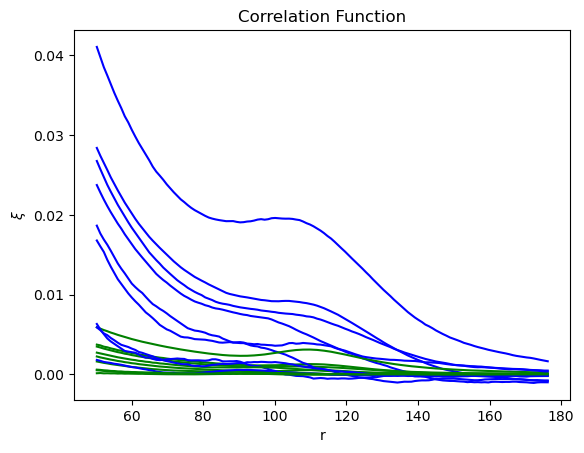

In [3]:
start=50 # start and end indices (not necessarily r)
end=180
for x in range(0,9): # simulation numbers to plot (0-2000)
    tablexz0 = txt_to_table(x, 0)[start:end] # z = 0
    tablexz3 = txt_to_table(x, 3)[start:end] # z = 3
    
    
    plt.plot(tablexz0['r'], tablexz0['xi'], c='b')
    plt.plot(tablexz3['r'], tablexz3['xi'], c='g')

    plt.xlabel('r')
    plt.ylabel('$\\xi$')
    plt.title('Correlation Function')

#### Xi r^2 vs. r truncated

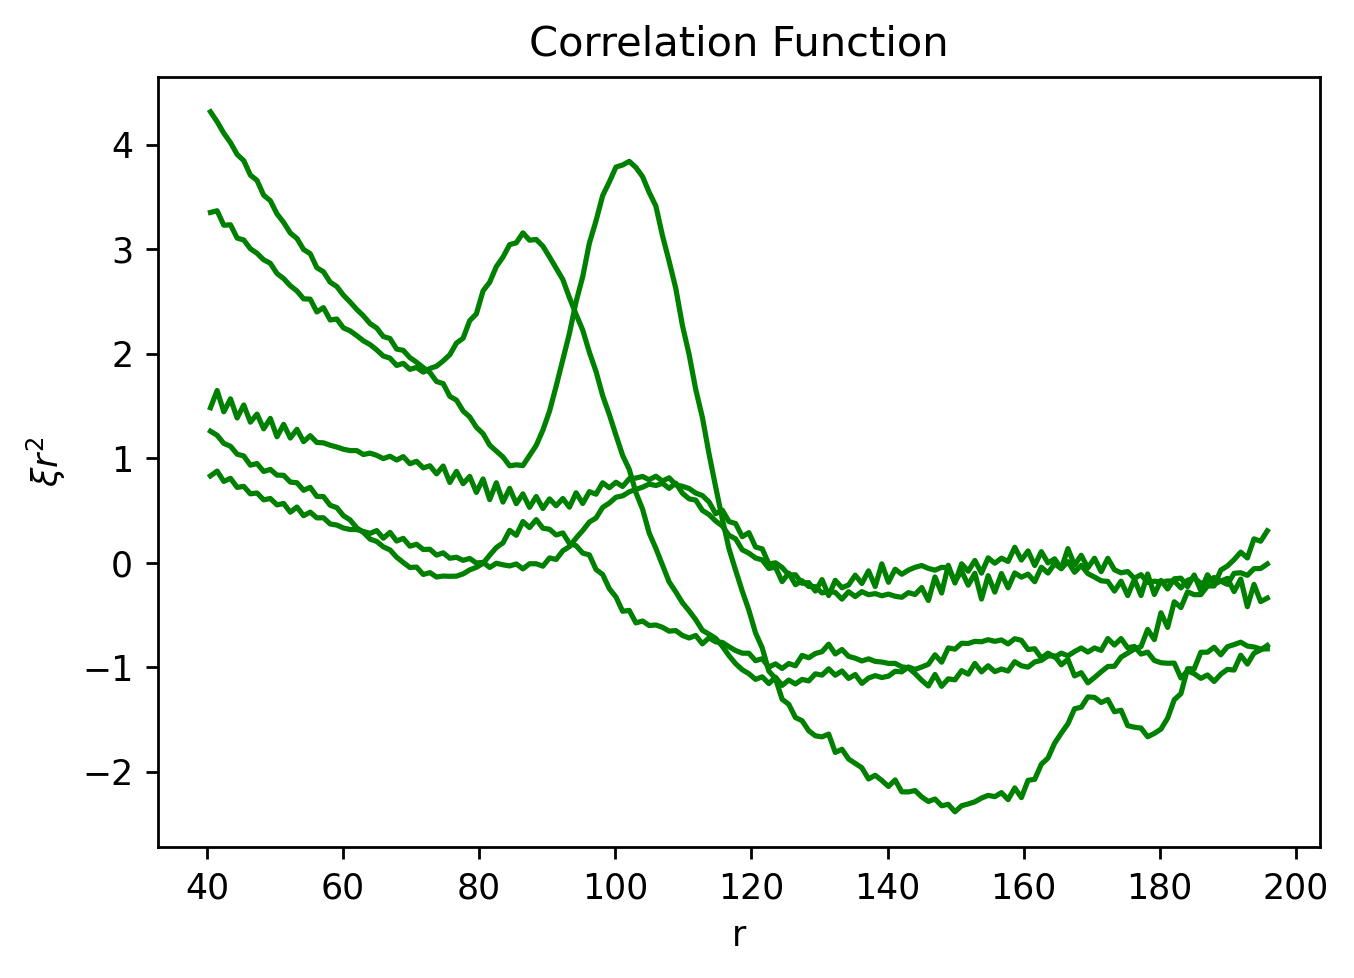

In [4]:
start=40 # start and end indices (not necessarily r)
end=200


fig = plt.figure(figsize=[6,4], dpi=250)
for x in range(1610, 1615): # simulation numbers to plot (0-2000)
    tablexz0 = txt_to_table(x, 0)[start:end] # z = 0
    tablexz3 = txt_to_table(x, 3)[start:end] # z = 3
    
    #plt.plot(tablexz0['r'], tablexz0['xi']*tablexz0['r']**2, c='b')
    plt.plot(tablexz3['r'], tablexz3['xi']*tablexz3['r']**2, c='g')
    
    plt.xlabel('r')
    plt.ylabel('$\\xi r^2$')
    plt.title('Correlation Function')

In [5]:
def changeBinsize(r, xi, boxsize, Nhalos, bw):
    r, xi = np.array(r), np.array(xi)
    bw0 = np.mean(np.diff(r))
    if bw < bw0:
        raise('The new bin width should be larger than the current size.')
        
    RR = np.array([])
    for ri in r:
        ri1, ri2 = ri - bw0/2, ri + bw0/2
        Vi = 4/3 * np.pi * (ri2**3 - ri1**3)
        RRi = Vi * Nhalos * (Nhalos - 1)/(boxsize**3)
        RR = np.append(RR, RRi)
        
    DD = xi * RR
    
    rmin = r.min() - bw0/2
    rmax = r.max() + bw0/2
    bins = np.arange(rmin, rmax+bw, bw)
    r_new = 0.5*(bins[1:]+ bins[:-1])

    DD_new = np.array([])
    for i in range(len(r_new)):
        ind = int(bw*i) + np.arange(int(bw))
        DD_new = np.append(DD_new, np.sum(DD[ind]))
        
    RR_new = np.array([])
    for ri in r_new:
        ri1, ri2 = ri - bw/2, ri + bw/2
        Vi = 4/3 * np.pi * (ri2**3 - ri1**3)
        RRi = Vi * Nhalos * (Nhalos - 1)/(boxsize**3)
        RR_new = np.append(RR_new, RRi)
    
    xi_new = DD_new/RR_new
    
    return r_new, xi_new

In [10]:
tablexz3 = txt_to_table(100, 3)#[start:end] # z = 3
binnedTable = binCorr(tablexz3, binning)

In [ ]:
rad = tablexz3['r']
xi = tablexz3['xi']

rSpacing = np.mean(np.diff(rad))
binSize=2

In [ ]:
radBins = rad[0:-1:binSize] 
radBinBounds = x[:-1] + 0.5*np.diff(rad)[0:-1:binSize] # new bin boundaries
radBinCenters = radBinBounds[:-1] + np.diff(radBinBounds)/2.

In [7]:
def binCorr(corrTable, binSize):
    rad = corrTable['r']
    xi = corrTable['xi']
    
    rSpacing = np.diff(rad)
    
    npoints = binSize + 1 # binSize is the width of each bin, and there is one more point than bins
    
    radBins = rad[0:-1:binSize]
    originalBinWidths = 0.5*np.diff(rad)[0:-1:binSize]
    if len(radBins) > len(originalBinWidths):
        radBinBounds = radBins[:-1] + 0.5*np.diff(rad)[0:-1:binSize] # new bin boundaries
    else:
        radBinBounds = radBins + 0.5*np.diff(rad)[0:-1:binSize] # new bin boundaries

    newRad = radBinBounds[:-1] + np.diff(radBinBounds)/2. # new bin centers
    binWidths = np.diff(radBinBounds)/2.

    newCorrTable = np.zeros(len(newRad))
    
    for i in range(len(newRad)):
        newCorr = 0
        for j in range(binSize):
            point = binSize*i + j + 1
            spacePoint = binSize*i + j
            pointCorr = ((rad[point] + (rSpacing[spacePoint+1]/2))**3 - (rad[point] - (rSpacing[spacePoint]/2))**3)*xi[point]
            newCorr += pointCorr
        

        newCorr /= ((newRad[i] + binWidths[i])**3 - (newRad[i] - binWidths[i])**3)
        
        newCorrTable[i] = newCorr
    

        
    
    binnedTable = Table([newRad, newCorrTable], names=('r', 'xi')) # astropy table

    return binnedTable
    
    
    

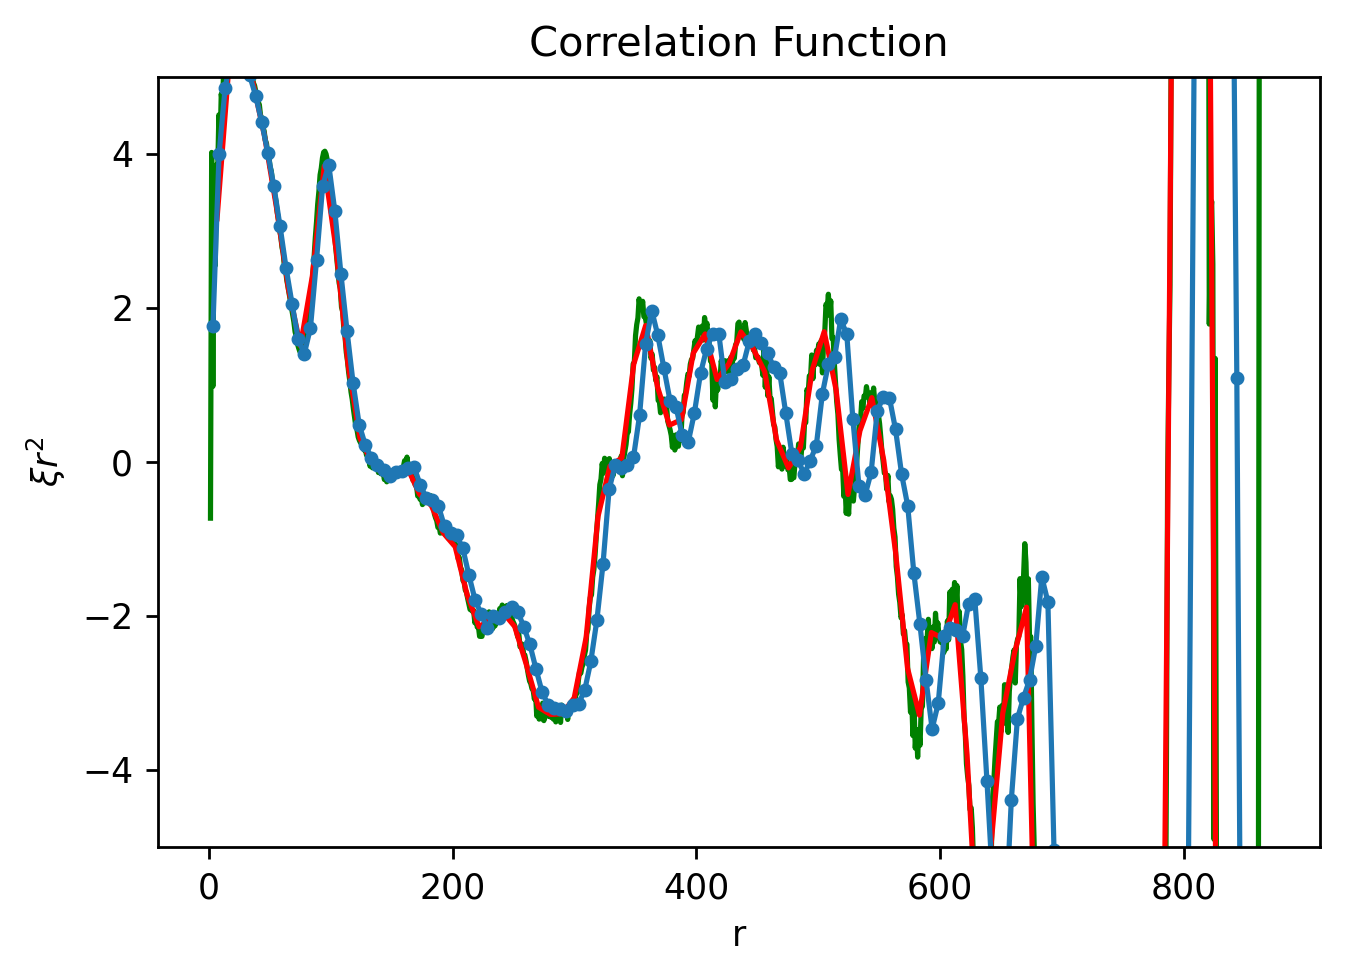

In [9]:
binning = 10

fig = plt.figure(figsize=[6,4], dpi=250)
for x in range(100, 101): # simulation numbers to plot (0-2000)
    tablexz3 = txt_to_table(x, 3)
    
    binnedTable = binCorr(tablexz3, binning)
    binnedTable2R, binnedTable2Xi = changeBinsize(tablexz3['r'], tablexz3['xi'], 1000, 512**3, 5)
    
    plt.plot(tablexz3['r'], tablexz3['xi']*tablexz3['r']**2, c='g')
    plt.plot(binnedTable['r'], binnedTable['xi']*binnedTable['r']**2, c='r')
    
    
    plt.plot(binnedTable2R, binnedTable2Xi*binnedTable2R**2, marker='.')
    
    # print(np.diff(binnedTable['rBin']), np.diff(tablexz3['r']))
    
    
    #plt.xlim(50, 150)
    plt.ylim(-5, 5)
    plt.xlabel('r')
    plt.ylabel('$\\xi r^2$')
    plt.title('Correlation Function')